# Basic Cell Clustering Using 100Kb Bins

## Content

Here we go through the basic steps to perform cell clustering using genome non-overlapping 100Kb bins as features.
We start from raw methylation base count data stored in MCDS format.
This notebook can be used to quickly evaluate cell-type composition in a single-cell methylome dataset
(e.g., the dataset from a single experiment).

### Dataset used in this notebook
- Adult (age P56) male mouse brain hippocampus (HIP) snmC-seq2 data from {cite}`Liu2021`.

## Input
- MCDS files (contains chrom100k count matrix)
- Cell metadata

## Output
- Cell-by-100kb-bin AnnData with embedding coordinates and cluster labels.

## Import

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc

from ALLCools.mcds import MCDS
from ALLCools.clustering import tsne, significant_pc_test, log_scale
from ALLCools.plot import *

In [3]:
from ALLCools.dataset import ALLCoolsDataset

brain_dataset = ALLCoolsDataset('/gale/netapp/cemba3c/projects/ALLCools/Brain/snmC-seq2/')

## Load Cell Metadata

In [4]:
metadata = pd.read_csv(brain_dataset.metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 4875 cells


AllcPath  mCCCFrac  \
8E_M_10    /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.005505   
8E_M_100   /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.004702   
8E_M_1000  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005423   
8E_M_1002  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.004117   
8E_M_1003  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005528   

            mCGFrac  mCGFracAdj   mCHFrac  mCHFracAdj  FinalReads  InputReads  \
8E_M_10    0.744279    0.742863  0.020649    0.015228   2714916.0     6036476   
8E_M_100   0.723100    0.721792  0.012400    0.007735   3302547.0     7683706   
8E_M_1000  0.739960    0.738542  0.021733    0.016399   1369094.0     3658050   
8E_M_1002  0.745511    0.744459  0.010192    0.006101   4571390.0    11822434   
8E_M_1003  0.750461    0.749074  0.023083    0.017652   1334845.0     3479288   

           MappedReads DissectionRegion  BamFilteringRate  MappingRate  \
8E_M_10      4014048.0               8E          0.676354     0.664965   
8E_M_100     5370970.0               8E          0.614888     0.699008   
8E_M_1000    2381916.0               8E          0.574787     0.651144   
8E_M_1002    8079217.0               8E          0.565821     0.683380   
8E_M_1003    2337068.0               8E          0.571162     0.671709   

                      Plate  Col384  Row384  FANSDate  Slice     Sample  
8E_M_10    CEMBA190711-8E-1      19       0    190711      8  8E_190711  
8E_M_100   CEMBA190711-8E-2       1       2    190711      8  8E_190711  
8E_M_1000  CEMBA190711-8E-4       6       5    190711      8  8E_190711  
8E_M_1002  CEMBA190711-8E-4       7       5    190711      8  8E_190711  
8E_M_1003  CEMBA190711-8E-3       8       4    190711      8  8E_190711

## Load MCDS

In [5]:
mcds = MCDS.open(
    brain_dataset.mcds_paths,
    obs_dim='cell',
    var_dim='chrom100k',
    use_obs=metadata.index  # MCDS contains all cells, this will select cells that passed filtering 
)
total_feature = mcds.get_index('chrom100k').size
mcds

<xarray.MCDS>
Dimensions:          (chrom100k: 27269, cell: 4875, count_type: 2, mc_type: 2)
Coordinates:
  * chrom100k        (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrY_917'
  * cell             (cell) <U15 '8E_M_3022' '8E_M_2746' ... '8J_M_2288'
  * count_type       (count_type) <U3 'mc' 'cov'
  * mc_type          (mc_type) <U3 'CGN' 'CHN'
Data variables:
    chrom100k_chrom  (chrom100k) <U5 dask.array<chunksize=(2000,), meta=np.ndarray>
    chrom100k_da     (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(1000, 2000, 2, 2), meta=np.ndarray>
    chrom100k_end    (chrom100k) int64 dask.array<chunksize=(2000,), meta=np.ndarray>
    chrom100k_start  (chrom100k) int64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

In [7]:
# you can add the cell metadata into MCDS
mcds.add_cell_metadata(metadata)

## Filter Features

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


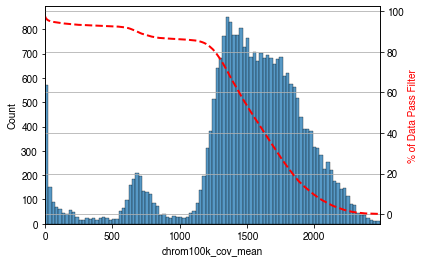

In [8]:
mcds.add_feature_cov_mean()

We saw three parts here with coverages from low to high, including:
1. Low coverage regions
2. chrX regions, because this dataset from male mouse brain
3. Other autosomal regions

In [9]:
# filter by coverage - based on the distribution above
# feature cov cutoffs
min_cov = 500
max_cov = 3000
mcds = mcds.filter_feature_by_cov_mean(
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # maximum coverage
)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 25233 chrom100k 92.5%


In [10]:
# remove chromosomes
exclude_chromosome = ['chrM', 'chrY']
mcds = mcds.remove_chromosome(exclude_chromosome)

40 chrom100k features in ['chrM', 'chrY'] removed.


In [11]:
# Regions to remove during the clustering analysis
# change this to the path to ENCODE blacklist.
# The ENCODE blacklist can be downloaded from https://github.com/Boyle-Lab/Blacklist/
black_list_fraction = 0.2
# remove blacklist regions
mcds = mcds.remove_black_list_region(
    black_list_path=brain_dataset.metadata_dir / 'mm10-blacklist.v2.bed.gz',
    f=black_list_fraction  # Features having overlap > f with any black list region will be removed.
)

1164 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


## Calculate Feature mC Fractions

In [13]:
mcds.add_mc_frac(
    normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
    clip_norm_value=10  # clip outlier values above 10 to 10
)

The RuntimeWarning is expected (due to cov == 0). You can ignore it.

## Select Highly Variable Features (HVF)

### mCH HVF

In [15]:
mch_hvf = mcds.calculate_hvf_svr(mc_type='CHN',
                                 n_top_feature=15000,
                                 plot=True)

/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Fitting SVR with gamma 0.0416, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     24040
Highly Variable Feature:  15000 (62.4%)


### mCG HVF

In [16]:
mcg_hvf = mcds.calculate_hvf_svr(mc_type='CGN',
                                 n_top_feature=15000,
                                 plot=True)

/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:

invalid value encountered in true_divide

/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:

invalid value encountered in true_divide



Fitting SVR with gamma 0.0416, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     24040
Highly Variable Feature:  15000 (62.4%)


## Get cell-by-feature mC fraction AnnData

In [17]:
mch_adata = mcds.get_adata(mc_type='CHN', select_hvf=True)
mch_adata

/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:

invalid value encountered in true_divide



AnnData object with n_obs × n_vars = 4875 × 15000
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample'
    var: 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'

In [18]:
mcg_adata = mcds.get_adata(mc_type='CGN', select_hvf=True)
mcg_adata

/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:

invalid value encountered in true_divide



AnnData object with n_obs × n_vars = 4875 × 15000
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample'
    var: 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'

## Scale

In [19]:
log_scale(mch_adata)

StandardScaler(with_mean=False)

In [20]:
log_scale(mcg_adata)

StandardScaler(with_mean=False)

## PCA

### mCH PCA

11 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4875, 50) to (4875, 11)
Red axis labels are used PCs


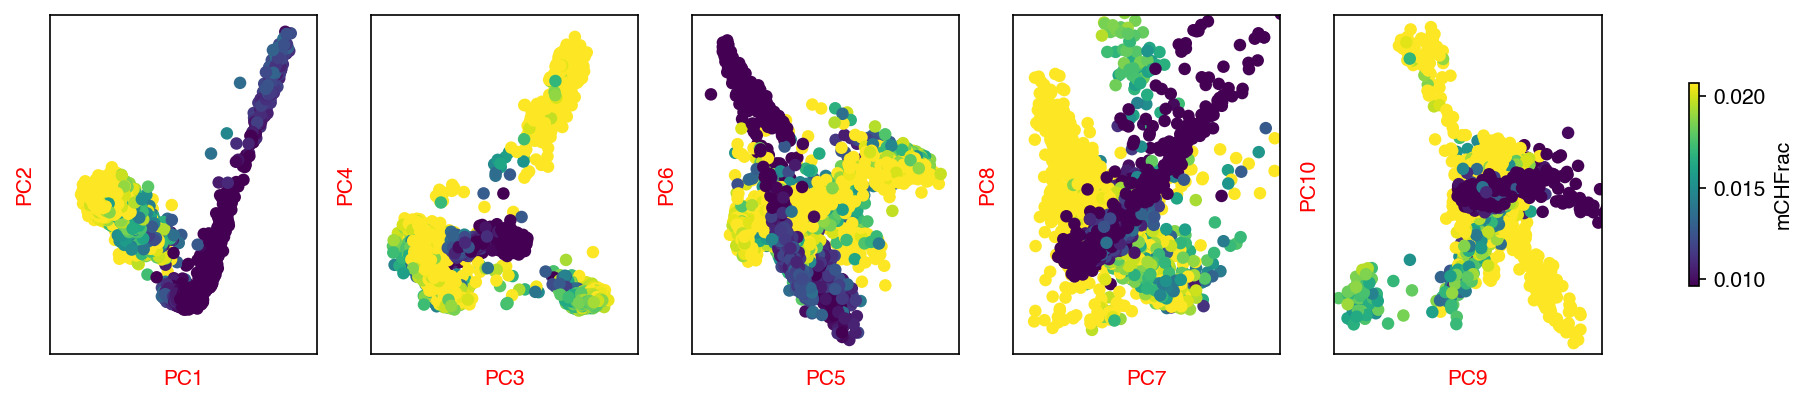

In [21]:
sc.tl.pca(mch_adata)
ch_n_components = significant_pc_test(mch_adata)
fig, axes = plot_decomp_scatters(mch_adata,
                                 n_components=ch_n_components,
                                 hue='mCHFrac',
                                 hue_quantile=(0.25, 0.75),
                                 nrows=1,
                                 ncols=5)

### mCG PCA

19 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4875, 50) to (4875, 19)
Red axis labels are used PCs


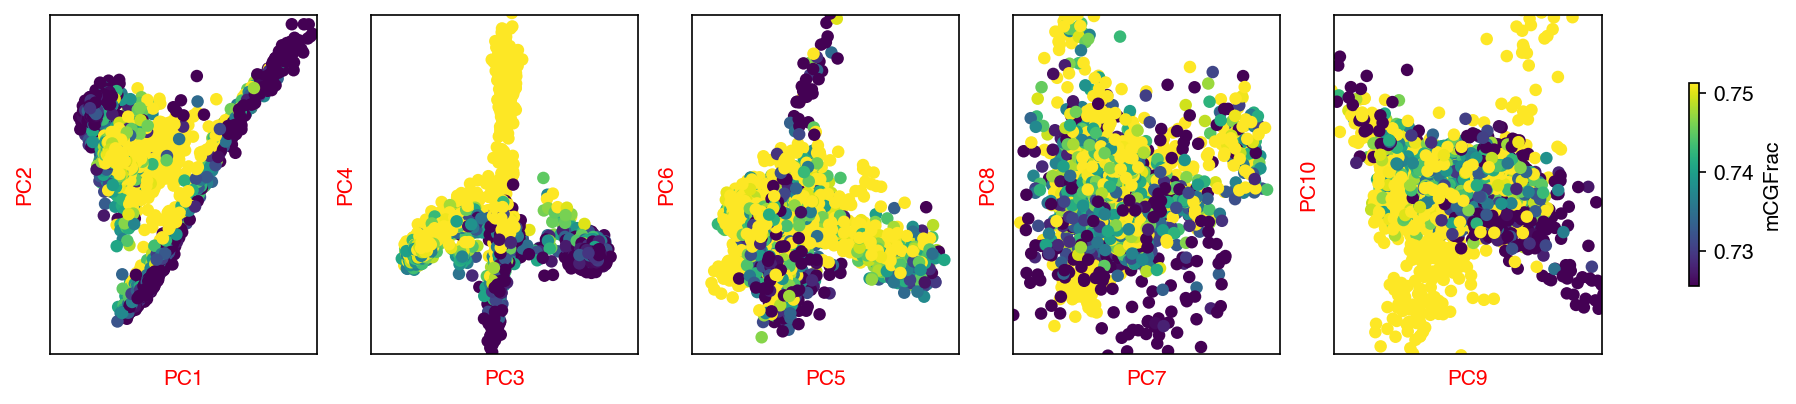

In [22]:
sc.tl.pca(mcg_adata)
cg_n_components = significant_pc_test(mcg_adata)
fig, axes = plot_decomp_scatters(mcg_adata,
                                 n_components=cg_n_components,
                                 hue='mCGFrac',
                                 hue_quantile=(0.25, 0.75),
                                 nrows=1,
                                 ncols=5)

### Concatenate PCs

In [23]:
ch_pcs = mch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = mcg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = mch_adata.copy()
adata.obsm['X_pca'] = total_pcs
del adata.uns['pca']
del adata.varm['PCs']

## Clustering

### Calculate Nearest Neighbors

In [24]:
sc.pp.neighbors(adata, n_neighbors=15)

2022-08-09 12:36:05.803500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 12:36:05.803541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Leiden Clustering

In [25]:
sc.tl.leiden(adata, resolution=1)

## Manifold learning

### tSNE

In [26]:
tsne(adata)

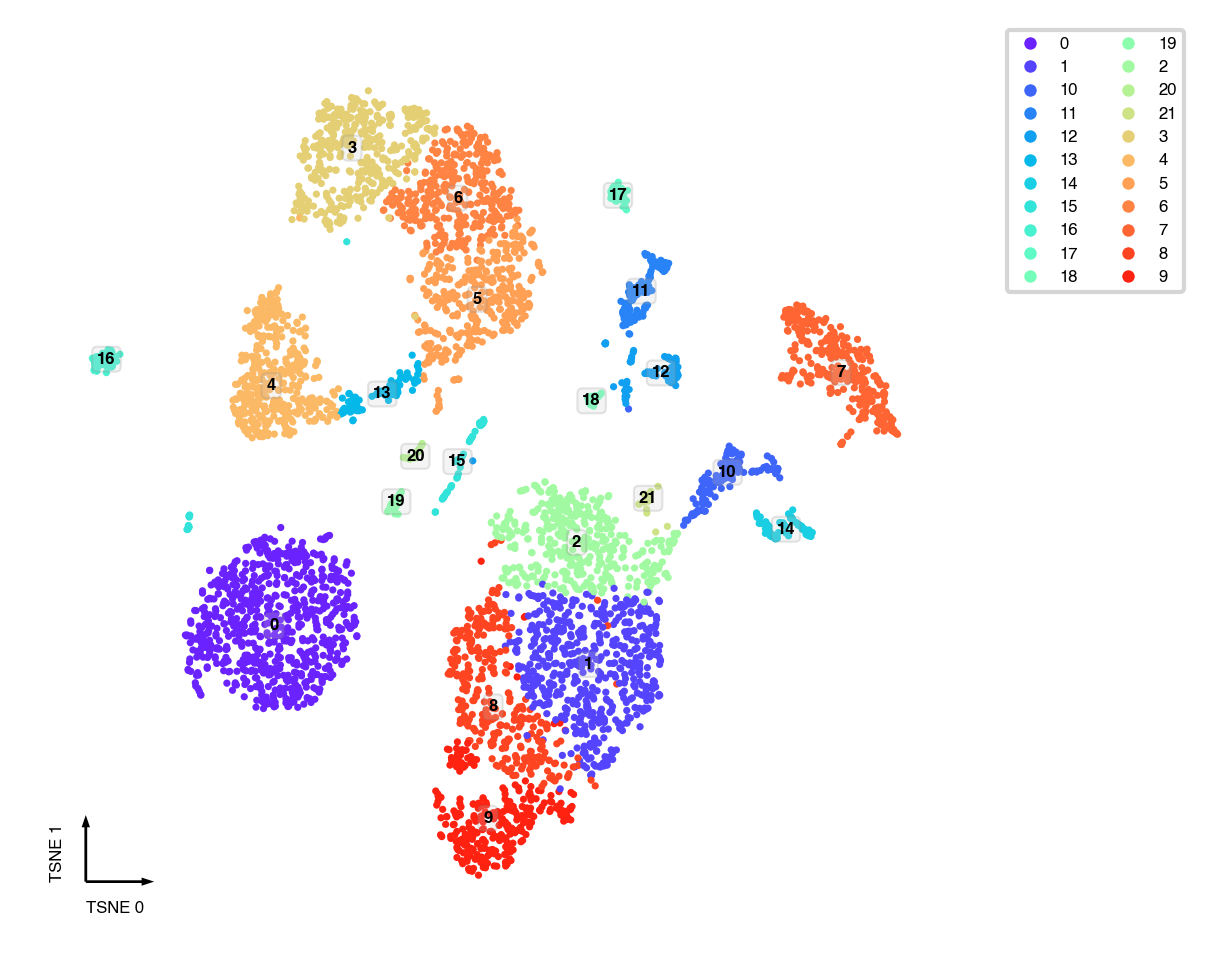

In [27]:
categorical_scatter(data=adata,
                    coord_base='tsne',
                    hue='leiden',
                    text_anno='leiden',
                    show_legend=True)

### UMAP

In [28]:
sc.tl.umap(adata)

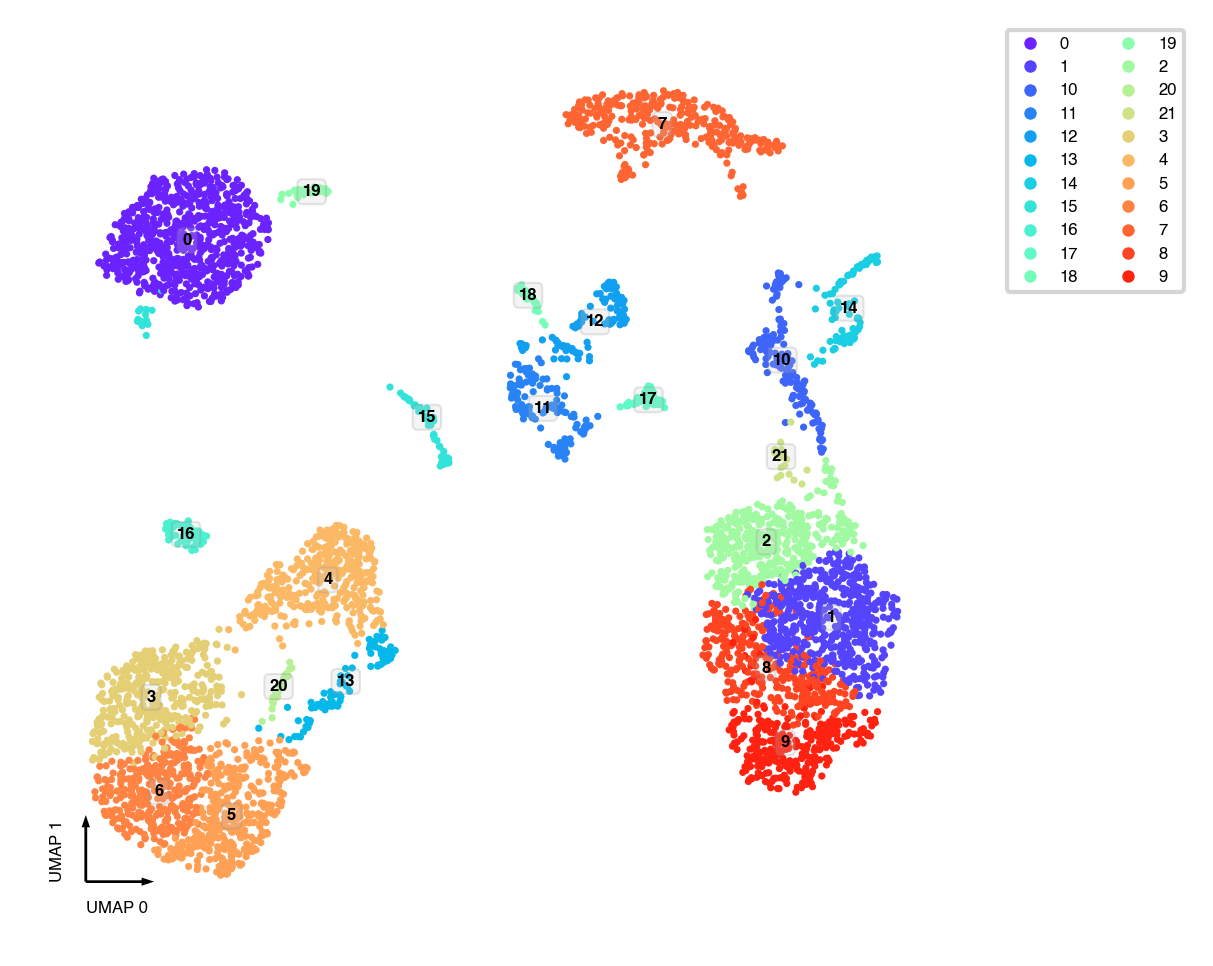

In [29]:
categorical_scatter(data=adata,
                    coord_base='umap',
                    hue='leiden',
                    text_anno='leiden',
                    show_legend=True)

### Interactive plot

In [30]:
# in order to reduce the page size, I downsample the data here, you don't need to do this
interactive_scatter(data=adata,
                    hue='leiden',
                    coord_base='umap',
                    max_points=3000)

## Save Results

In [31]:
adata.write_h5ad('Brain.chrom100k-clustering.h5ad')
adata

AnnData object with n_obs × n_vars = 4875 × 15000
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample', 'leiden'
    var: 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'
    uns: 'log', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

In [32]:
adata.obs.to_csv('Brain.ClusteringResults.csv.gz')
adata.obs.head()

AllcPath  mCCCFrac  \
cell                                                                     
8E_M_3022  /gale/raidix/rdx-4/mapping/8E/CEMBA190716-8E-3...  0.006022   
8E_M_2746  /gale/raidix/rdx-4/mapping/8E/CEMBA190716-8E-3...  0.005607   
8J_M_2510  /gale/raidix/rdx-4/mapping/8J/CEMBA190716-8J-3...  0.004732   
8J_M_2022  /gale/raidix/rdx-4/mapping/8J/CEMBA190716-8J-1...  0.005084   
8J_M_2335  /gale/raidix/rdx-4/mapping/8J/CEMBA190716-8J-3...  0.004643   

            mCGFrac  mCGFracAdj   mCHFrac  mCHFracAdj  FinalReads  InputReads  \
cell                                                                            
8E_M_3022  0.785486    0.784187  0.023654    0.017738   1518108.0     3559044   
8E_M_2746  0.788852    0.787661  0.022681    0.017171   1085655.0     2397746   
8J_M_2510  0.777435    0.776377  0.012699    0.008005   4000963.0    10036440   
8J_M_2022  0.824273    0.823375  0.015417    0.010386   1794729.0     4834116   
8J_M_2335  0.822066    0.821236  0.015837    0.011247   1541352.0     3676692   

           MappedReads DissectionRegion  BamFilteringRate  MappingRate  \
cell                                                                     
8E_M_3022    2389871.0               8E          0.635226     0.671492   
8E_M_2746    1629198.0               8E          0.666374     0.679471   
8J_M_2510    6943643.0               8J          0.576205     0.691843   
8J_M_2022    3300784.0               8J          0.543728     0.682810   
8J_M_2335    2479428.0               8J          0.621656     0.674364   

                      Plate  Col384  Row384  FANSDate  Slice     Sample leiden  
cell                                                                            
8E_M_3022  CEMBA190716-8E-3      14      15    190716      8  8E_190716     12  
8E_M_2746  CEMBA190716-8E-4      15       9    190716      8  8E_190716     12  
8J_M_2510  CEMBA190716-8J-4      14       4    190716      8  8J_190716     12  
8J_M_2022  CEMBA190716-8J-2       6      10    190716      8  8J_190716     12  
8J_M_2335  CEMBA190716-8J-3       0       2    190716      8  8J_190716     12

In [33]:
# this cell will not occur in the documentation
import subprocess

subprocess.run('rm -f Brain.ClusteringResults.csv.gz Brain.chrom100k-clustering.h5ad', shell=True)

CompletedProcess(args='rm -f Brain.ClusteringResults.csv.gz Brain.chrom100k-clustering.h5ad', returncode=0)